# SITCOM-797 Slewing Analysis - Positioning

To analyze the positioning system after a slew, create plots for the mirror

- decentering (X and Y)
- mirror tilt (RX, RY, RY)
- piston
- Create a histogram for each parameter for a configurable time period.

Include the limits in all plots:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree (0.0864 arcsec)
* piston less than +/- 1 micrometer

# Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import time
from astropy import units as u
import matplotlib.dates as mdates

from scipy.stats import linregress

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [3]:
# Select data from a given date
# dayObs = [20230627] # 486 slews - most of them with small amplitude (< 20 degrees)
# dayObs = [20230711] # 37 slews - Some with large amplitude
# dayObs = [20230710] # 86 slews - Some with large amplitude

# dayObs is a list of observation date
dayObs = [20230711, 20230710]

eventMaker = TMAEventMaker()
for i, d in enumerate(dayObs):
    if i == 0:
        events = eventMaker.getEvents(d)
    else:
        events = events + eventMaker.getEvents(d)

# Get lists of slew events
slews = [e for e in events if e.type == TMAState.SLEWING]
print(f"Found {len(slews)} slews")

Found 123 slews


In [4]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

In [5]:
pos_columns = ["xPosition", "yPosition", "zPosition"]
rot_columns = ["xRotation", "yRotation", "zRotation"]
all_columns = pos_columns + rot_columns

# Compute intermediate values that will be used later in the analysis

* Loop over all the slews
* Compute relevant quantities from the EFD
* Store results in a dataframe in order to plot them later
***
For each slew we record the following quantities:
 * **i_slew**: Slew number
 * **duration**: Slew duration
 * **x_mean, y_mean, z_mean**: Average positions
 * **x_sigma, y_sigma, z_sigma**: Sigma on positions
 * **R_x_mean, R_y_mean, R_z_mean**: Average rotations
 * **Rx_sigma, Ry_sigma, Rz_sigma**: Sigma on rotations
 * **dx_max, dy_max, dz_max**: Maximum excursion in position w.r.t. initial position
 * **R_dx_max, R_dy_max, R_dz_max**: Maximum excursion in rotation w.r.t. intitial rotation angle
 * **x_before, y_before, z_before**: Position before slew averaged over a small delta t)
 * **R_x_before, R_y_before, R_z_before**: Rotation angle before slew averaged over a small delta t)
 * **x_after, y_after, z_after**: Position after slew averaged over a small delta t)
 * **R_x_after, R_y_after, R_z_after**: Rotation angle after slew averaged over a small delta t)
 * **start_ele, end_ele**: Elevation angle at the beginning and at the end of the slew
 * **start_azi, end_azi**: Azimuth angle at the beginning and at the end of the slew
 * **speed_ele**: Elevation speed
 * **slew_end**: Timestamp when slew ends

In [6]:
# define small amount of time to check mirror position before and after the slews
delta_t = 1
dt_begin = time.TimeDelta(-delta_t, format="sec")
dt_end = time.TimeDelta(delta_t, format="sec")

results = pd.DataFrame(
    columns=[
        "i_slew",
        "duration",
        "x_mean",
        "y_mean",
        "z_mean",
        "x_sigma",
        "y_sigma",
        "z_sigma",
        "R_x_mean",
        "R_y_mean",
        "R_z_mean",
        "Rx_sigma",
        "Ry_sigma",
        "Rz_sigma",
        "dx_max",
        "dy_max",
        "dz_max",
        "R_dx_max",
        "R_dy_max",
        "R_dz_max",
        "x_before",
        "y_before",
        "z_before",
        "R_x_before",
        "R_y_before",
        "R_z_before",
        "x_after",
        "y_after",
        "z_after",
        "R_x_after",
        "R_y_after",
        "R_z_after",
        "start_ele",
        "end_ele",
        "start_azi",
        "end_azi",
        "speed_ele",
        "slew_end",
    ]
)

for i_slew, slew in enumerate(slews):
    # Get ims data
    df_ims = getEfdData(client, "lsst.sal.MTM1M3.imsData", event=slew)
    if len(df_ims) == 0:
        print(f"No data for slew number: {i_slew}")
        continue

    df_ims = df_ims[all_columns]

    # Convert meter to milimeter to make is easier to analyse
    df_ims[pos_columns] = df_ims[pos_columns] * u.m.to(u.mm)

    # get ims data before and after the slew
    df_ims_before = getEfdData(
        client, "lsst.sal.MTM1M3.imsData", begin=slew.begin, timespan=dt_begin
    )
    if len(df_ims_before) == 0:
        print(f"No data before slew number: {i_slew}")
        continue
    df_ims_before = df_ims_before[all_columns]
    df_ims_before[pos_columns] = df_ims_before[pos_columns] * u.m.to(u.mm)

    df_ims_after = getEfdData(
        client, "lsst.sal.MTM1M3.imsData", begin=slew.end, timespan=dt_end
    )
    if len(df_ims_before) == 0:
        print(f"No data after slew number: {i_slew}")
        continue
    df_ims_after = df_ims_after[all_columns]
    df_ims_after[pos_columns] = df_ims_after[pos_columns] * u.m.to(u.mm)

    # In order to avoid duplicating code for the various positions / rotations we store results in dictionaries
    # with keys equal to xPosition, yPosition, ... xRotation, ...
    mean = {}
    sigma = {}
    max_diff = {}
    mean_before = {}
    mean_after = {}
    for col in all_columns:
        mean[col] = np.mean(df_ims[col])
        sigma[col] = np.std(df_ims[col])
        t0 = df_ims.index[0]
        max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0] - df_ims[col]))

        mean_before[col] = np.mean(df_ims_before[col])
        mean_after[col] = np.mean(df_ims_after[col])

    # get elevation data
    df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", event=slew)
    pos_ele = df_ele["actualPosition"]
    start_ele = pos_ele[pos_ele.index[0]]
    end_ele = pos_ele[pos_ele.index[len(pos_ele) - 1]]
    # get speed
    speed_ele = np.mean(df_ele["demandVelocity"])

    # get azimuth data
    df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", event=slew)
    pos_azi = df_azi["actualPosition"]
    start_azi = pos_azi[pos_azi.index[0]]
    end_azi = pos_azi[pos_azi.index[len(pos_azi) - 1]]

    # Store computed values in dataframe
    # Pandas requires the values in each rows to be passed as a flat vector
    # First we need to extract the values from the dictionaries
    vect = [
        [i_slew],
        [slew.duration],
        [mean[i] for i in pos_columns],
        [sigma[i] for i in pos_columns],
        [mean[i] for i in rot_columns],
        [sigma[i] for i in rot_columns],
        [max_diff[i] for i in pos_columns],
        [max_diff[i] for i in rot_columns],
        [mean_before[i] for i in pos_columns],
        [mean_before[i] for i in rot_columns],
        [mean_after[i] for i in pos_columns],
        [mean_after[i] for i in rot_columns],
        [start_ele],
        [end_ele],
        [start_azi],
        [end_azi],
        [speed_ele],
        [slew.end],
    ]
    flat_vect = [item for sublist in vect for item in sublist]
    results = pd.concat(
        [results, pd.DataFrame([flat_vect], columns=results.columns)], ignore_index=True
    )

In [7]:
# Print out the results dataframe
results

,i_slew,duration,x_mean,y_mean,z_mean,x_sigma,y_sigma,z_sigma,R_x_mean,R_y_mean,...,z_after,R_x_after,R_y_after,R_z_after,start_ele,end_ele,start_azi,end_azi,speed_ele,slew_end
0,0,10.529821,-1.467891,5.573259,-1.090555,0.000122,0.000070,0.000050,-0.002689,-0.014370,...,-1.090561,-0.002690,-0.014370,0.008361,89.857499,89.857499,152.960205,151.974922,0.000000e+00,1689098556.3483126
1,1,18.661617,-1.467867,5.571195,-1.090376,0.000125,0.000534,0.000140,-0.002692,-0.014373,...,-1.090230,-0.002678,-0.014373,0.008348,89.857500,88.054417,151.942485,151.942484,-9.738160e-02,1689098579.7710545
2,2,9.975383,-1.467728,5.571993,-1.089816,0.000047,0.000105,0.000038,-0.002680,-0.014369,...,-1.089875,-0.002682,-0.014369,0.008357,88.020001,88.020000,151.924107,150.992820,0.000000e+00,1689098844.6797037
3,3,18.696425,-1.467638,5.570002,-1.089654,0.000123,0.000548,0.000082,-0.002682,-0.014374,...,-1.089556,-0.002669,-0.014372,0.008344,88.020000,86.215425,150.952580,150.952579,-9.757140e-02,1689098868.1366441
4,4,171.711508,-1.467674,5.553286,-1.095379,0.000319,0.007948,0.006304,-0.002680,-0.014374,...,-1.110488,-0.002746,-0.014346,0.008277,86.218937,43.550930,150.952579,150.952580,-2.489274e-01,1689099116.0145297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,118,52.920417,-1.464753,5.550458,-1.121309,0.003760,0.002430,0.000671,-0.003003,-0.014246,...,-1.117816,-0.003031,-0.014192,0.008298,45.000000,45.000003,250.000000,70.020121,-9.939233e-17,1689065675.140582
119,119,24.385177,-1.466672,5.590621,-1.118671,0.000813,0.011763,0.009372,-0.002823,-0.014276,...,-1.100636,-0.002874,-0.014237,0.008380,45.000001,84.988886,70.000000,70.000000,1.646521e+00,1689065749.3774822
120,120,10.650323,-1.465643,5.576128,-1.099188,0.000055,0.000144,0.000020,-0.002923,-0.014262,...,-1.099239,-0.002924,-0.014262,0.008377,84.937500,84.937498,70.005406,69.008125,0.000000e+00,1689066198.8363364
121,121,17.328240,-1.465661,5.574249,-1.099100,0.000047,0.000567,0.000053,-0.002925,-0.014265,...,-1.099059,-0.002913,-0.014265,0.008364,84.937499,83.264624,68.940378,68.940378,-9.758735e-02,1689066220.999926


# The analysis is starting here

We use the results dataframe to create plots

# Histogram of the difference between positions / rotations after and before the slews

### In this first analysis, we compare the positions and rotations given by the IMS at the end of the slews to the one at the start of the slews.

Outliers are excluded from the analysis but it would be interesting to investigate the origin of these outliers

Found 1 outliers xPosition (limit: 100 microns)
Found 23 outliers xRotation (limit: 0.55 arcsec)
Found 4 outliers yPosition (limit: 100 microns)
Found 3 outliers yRotation (limit: 0.55 arcsec)
Found 4 outliers zPosition (limit: 100 microns)
Found 12 outliers zRotation (limit: 0.55 arcsec)


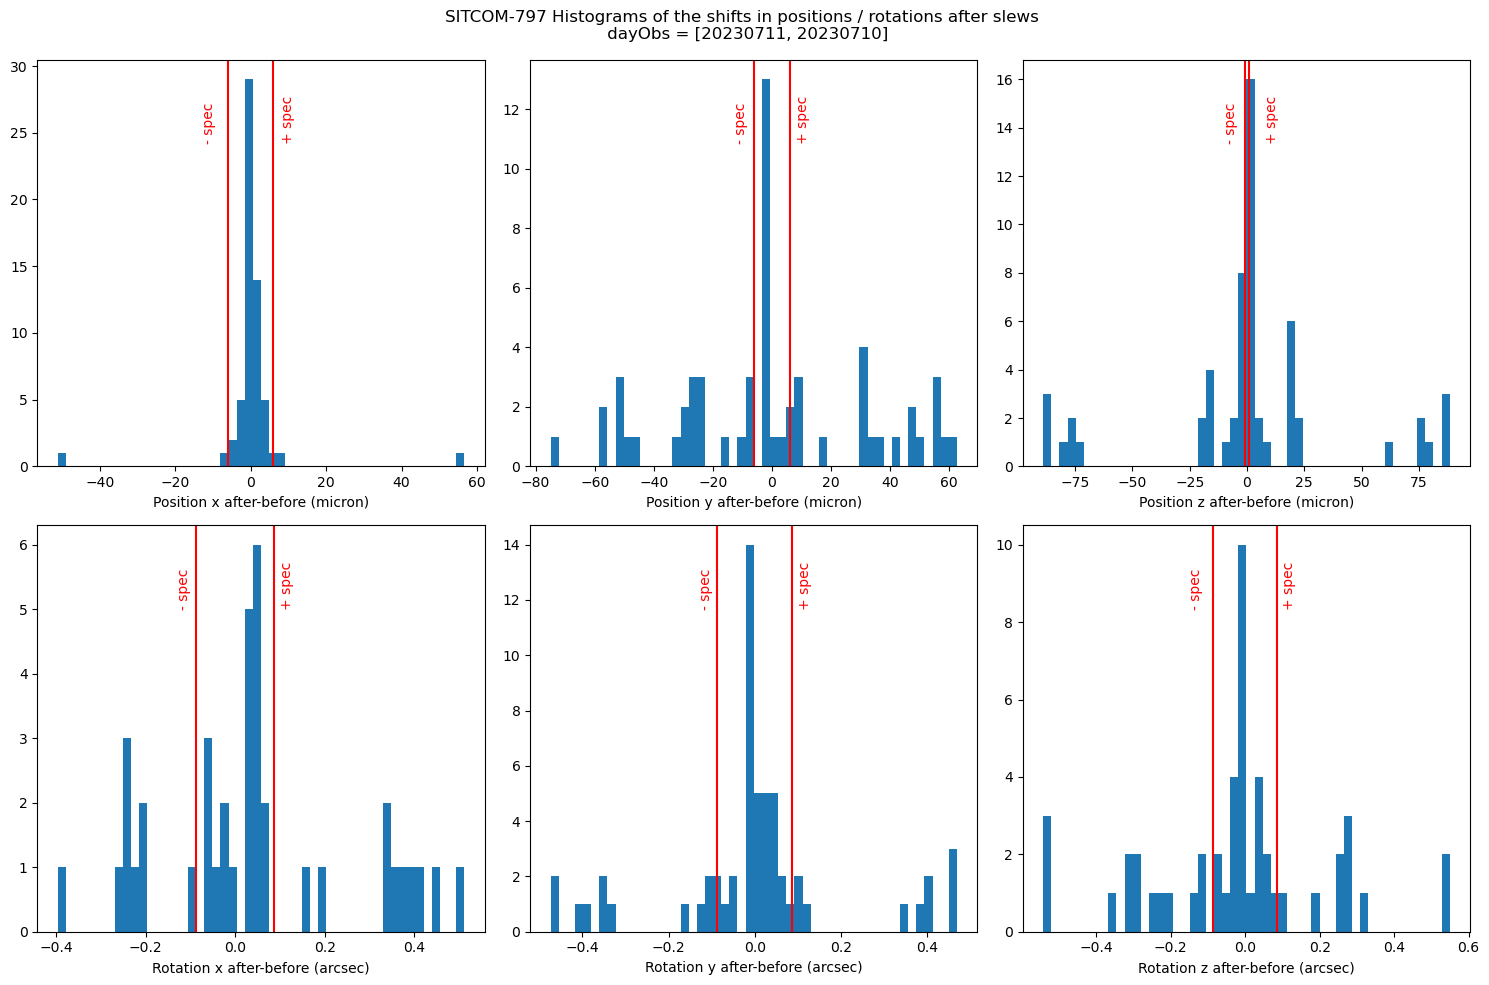

In [8]:
%matplotlib inline

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

axes = "xyz"

# limit on position (micron) or rotation (arcsec) for outliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Histograms of the shifts in positions / rotations after slews \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 10))

# Check whether the TMA actually move in elevation
mask_move = abs(results["speed_ele"]) > 0.05

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = np.abs(diff) < out_limit_pos
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    axs[0][i].hist(diff[mask], bins=50)
    axs[0][i].set_xlabel(f"Position {axes[i]} after-before (micron)")

    R_diff = (
        results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    axs[1][i].hist(R_diff[mask], bins=50)
    axs[1][i].set_xlabel(f"Rotation {axes[i]} after-before (arcsec)")

    # add lines and labels for tolerances
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color="r")
        axs[0][i].axvline(-6, color="r")
        axs[0][i].text(
            -13,
            0.8,
            "- spec",
            rotation=90,
            transform=axs[0][i].get_xaxis_transform(),
            color="r",
        )
        axs[0][i].text(
            8,
            0.8,
            "+ spec",
            rotation=90,
            transform=axs[0][i].get_xaxis_transform(),
            color="r",
        )
        axs[1][i].axvline(0.0864, color="r")
        axs[1][i].axvline(-0.0864, color="r")
        axs[1][i].text(
            -0.13,
            0.8,
            "- spec",
            rotation=90,
            transform=axs[1][i].get_xaxis_transform(),
            color="r",
        )
        axs[1][i].text(
            0.10,
            0.8,
            "+ spec",
            rotation=90,
            transform=axs[1][i].get_xaxis_transform(),
            color="r",
        )

    else:
        axs[0][i].axvline(1, color="r")
        axs[0][i].axvline(-1, color="r")
        axs[0][i].text(
            -10,
            0.8,
            "- spec",
            rotation=90,
            transform=axs[0][i].get_xaxis_transform(),
            color="r",
        )
        axs[0][i].text(
            8,
            0.8,
            "+ spec",
            rotation=90,
            transform=axs[0][i].get_xaxis_transform(),
            color="r",
        )
        axs[1][i].axvline(0.0864, color="r")
        axs[1][i].axvline(-0.0864, color="r")
        axs[1][i].text(
            -0.15,
            0.8,
            "- spec",
            rotation=90,
            transform=axs[1][i].get_xaxis_transform(),
            color="r",
        )
        axs[1][i].text(
            0.1,
            0.8,
            "+ spec",
            rotation=90,
            transform=axs[1][i].get_xaxis_transform(),
            color="r",
        )

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

## Conclusion

The mirror displacement during slew is out of specifications, especially for what concerns the piston (z position)

## Check whether the mirror displacement is correlated to the elevation difference ( end of slew - start of slew)

Found 1 outliers xPosition (limit: 100 microns)
Found 23 outliers xRotation (limit: 0.55 arcsec)
Found 4 outliers yPosition (limit: 100 microns)
Found 3 outliers yRotation (limit: 0.55 arcsec)
Found 4 outliers zPosition (limit: 100 microns)
Found 12 outliers zRotation (limit: 0.55 arcsec)


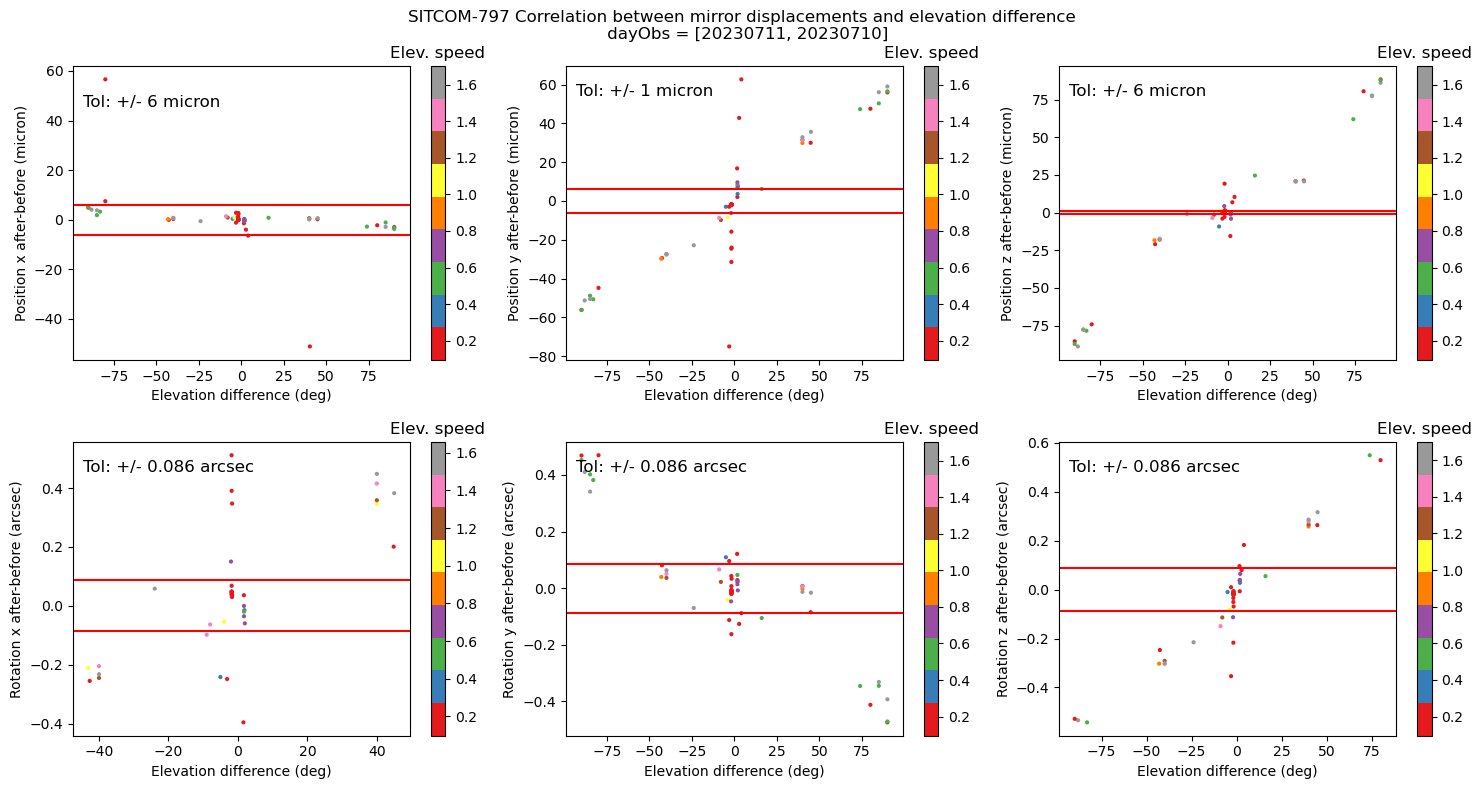

In [9]:
# The color scale represents the slew speed

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

plt.rc("text", usetex=False)

cm = matplotlib.colormaps["Set1"]

axes = ["x", "y", "z"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Correlation between mirror displacements and elevation difference \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in elevation
# mask_move = abs(results["end_ele"] - results["start_ele"]) > 1
mask_move = abs(results["speed_ele"]) > 0.05

diff_ele = results["end_ele"] - results["start_ele"]

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = np.abs(diff) < out_limit_pos
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    im = axs[0][i].scatter(
        diff_ele[mask], diff[mask], c=abs(results["speed_ele"][mask]), s=4, cmap=cm
    )
    axs[0][i].set_xlabel("Elevation difference (deg)")
    axs[0][i].set_ylabel(f"Position {axes[i]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title("Elev. speed")

    R_diff = (
        results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    im = axs[1][i].scatter(
        diff_ele[mask], R_diff[mask], c=abs(results["speed_ele"][mask]), s=4, cmap=cm
    )
    axs[1][i].set_xlabel("Elevation difference (deg)")
    axs[1][i].set_ylabel(f"Rotation {axes[i]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title("Elev. speed")

    if axes[i] in ["x", "y"]:
        axs[0][i].axhline(6, color="r")
        axs[0][i].axhline(-6, color="r")
        if i == 0:
            axs[0][i].text(
                0.03,
                0.90,
                "Tol: +/- 6 micron",
                transform=axs[0][i].transAxes,
                fontsize=12,
                verticalalignment="top",
            )
        else:
            axs[0][i].text(
                0.03,
                0.94,
                "Tol: +/- 1 micron",
                transform=axs[0][i].transAxes,
                fontsize=12,
                verticalalignment="top",
            )
        axs[1][i].axhline(0.0864, color="r")
        axs[1][i].axhline(-0.0864, color="r")
        axs[1][i].text(
            0.03,
            0.94,
            "Tol: +/- 0.086 arcsec",
            transform=axs[1][i].transAxes,
            fontsize=12,
            verticalalignment="top",
        )
    else:
        axs[0][i].axhline(1, color="r")
        axs[0][i].axhline(-1, color="r")
        axs[0][i].text(
            0.03,
            0.94,
            "Tol: +/- 6 micron",
            transform=axs[0][i].transAxes,
            fontsize=12,
            verticalalignment="top",
        )
        axs[1][i].axhline(0.0864, color="r")
        axs[1][i].axhline(-0.0864, color="r")
        axs[1][i].text(
            0.03,
            0.94,
            "Tol: +/- 0.086 arcsec",
            transform=axs[1][i].transAxes,
            fontsize=12,
            verticalalignment="top",
        )

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Set of scatter plots to show the correlations between the various mirror movements and rotations

Found 4 outliers for pair xy (limit: 100 microns)
Found 23 outliers for pair xy (limit: 0.55 arcsec)
Found 4 outliers for pair yz (limit: 100 microns)
Found 12 outliers for pair yz (limit: 0.55 arcsec)
Found 4 outliers for pair xz (limit: 100 microns)
Found 23 outliers for pair xz (limit: 0.55 arcsec)


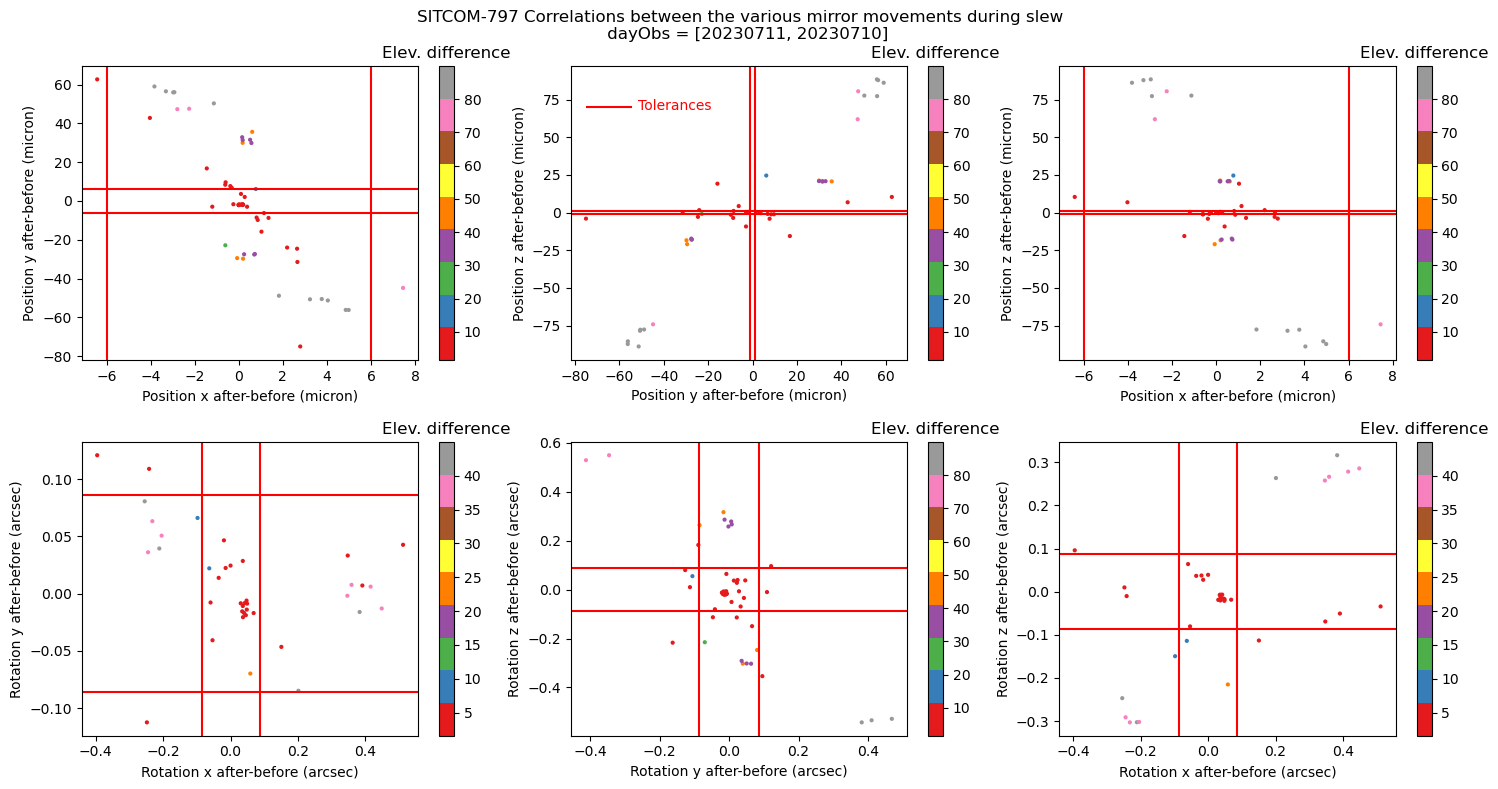

In [10]:
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

cm = matplotlib.colormaps["Set1"]

pairs = ["xy", "yz", "xz"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Correlations between the various mirror movements during slew  \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in elevation
mask_move = abs(results["speed_ele"]) > 0.05

# Elevation change
diff_ele = results["end_ele"] - results["start_ele"]

for i in range(3):
    pair = pairs[i]

    # Positions
    diff_1 = (results[f"{pair[0]}_after"] - results[f"{pair[0]}_before"]) * u.mm.to(
        u.micron
    )
    diff_2 = (results[f"{pair[1]}_after"] - results[f"{pair[1]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = (np.abs(diff_1) < out_limit_pos) & (np.abs(diff_2) < out_limit_pos)
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    im = axs[0][i].scatter(
        diff_1[mask], diff_2[mask], c=abs(diff_ele[mask]), s=4, cmap=cm
    )
    axs[0][i].set_xlabel(f"Position {pair[0]} after-before (micron)")
    axs[0][i].set_ylabel(f"Position {pair[1]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title("Elev. difference")

    if pair[0] == "x" or pair[0] == "r":
        axs[0][i].axvline(6, color="r")
        axs[0][i].axvline(-6, color="r")
    else:
        axs[0][i].axvline(1, color="r")
        axs[0][i].axvline(-1, color="r")

    if pair[1] == "x" or pair[1] == "y":
        axs[0][i].axhline(6, color="r")
        axs[0][i].axhline(-6, color="r")
    else:
        axs[0][i].axhline(1, color="r")
        axs[0][i].axhline(-1, color="r")

    # Rotations
    R_diff_1 = (
        results[f"R_{pair[0]}_after"] - results[f"R_{pair[0]}_before"]
    ) * u.degree.to(u.arcsec)
    R_diff_2 = (
        results[f"R_{pair[1]}_after"] - results[f"R_{pair[1]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = (np.abs(R_diff_1) < out_limit_rot) & (np.abs(R_diff_2) < out_limit_rot)
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    im = axs[1][i].scatter(
        R_diff_1[mask], R_diff_2[mask], c=abs(diff_ele[mask]), s=4, cmap=cm
    )
    axs[1][i].set_xlabel(f"Rotation {pair[0]} after-before (arcsec)")
    axs[1][i].set_ylabel(f"Rotation {pair[1]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title("Elev. difference")

    axs[1][i].axhline(0.0864, color="r")
    axs[1][i].axhline(-0.0864, color="r")
    axs[1][i].axvline(0.0864, color="r")
    axs[1][i].axvline(-0.0864, color="r")

axs[0][1].text(
    0.2,
    0.85,
    "Tolerances",
    transform=axs[0][1].transAxes,
    color="r",
)
axs[0][1].plot(
    [0.05, 0.18],
    [0.86, 0.86],
    linewidth=1.5,
    transform=axs[0][1].transAxes,
    color="r",
    linestyle="solid",
)

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Conclusions

 - We observe clear correlations between the mirror displacements / rotations during slews
 - The amplitude of the displacements / rotations is also correlated to the elevation difference

# Detailed analysis of a specific slew

## We select one specific large amplitude slew in order to analyse the variation of the positions / rotations as a function of time 

In [11]:
# Find the slew where the elevation difference is maximum
ele_index = np.argmax(diff_ele)
# ele_index=19
# ele_index=14
print(
    "Elevation difference of slew %i: %.1f degrees" % (ele_index, diff_ele[ele_index])
)
print(
    "Start elevattion is %.1f degrees - End elevation is %.1f degrees"
    % (results["start_ele"][ele_index], results["end_ele"][ele_index])
)

Elevation difference of slew 68: 90.0 degrees
Start elevattion is -0.0 degrees - End elevation is 89.9 degrees


In [12]:
# Get ims data covering the selected slew plus some extra time before and after the slew
delta_t = 40
dt_end = time.TimeDelta(delta_t, format="sec")
dt_begin = time.TimeDelta(delta_t, format="sec")
df_ims = getEfdData(
    client,
    "lsst.sal.MTM1M3.imsData",
    begin=slews[ele_index].begin - dt_begin,
    end=slews[ele_index].end + dt_end,
)

# We also retreive the data correesponding to the exact slew duration in order to be able to find the start and the end of the slew
df_ims_slew = getEfdData(
    client,
    "lsst.sal.MTM1M3.imsData",
    begin=slews[ele_index].begin,
    end=slews[ele_index].end,
)

In [13]:
df_ims

,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,rawSensorData0,rawSensorData1,...,rawSensorData5,rawSensorData6,rawSensorData7,timestamp,xPosition,xRotation,yPosition,yRotation,zPosition,zRotation
2023-07-11 06:22:13.322394+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5194907,1.689057e+09,30.818501,24.657000,...,25.3195,27.1460,23.671000,1.689057e+09,-0.001462,-0.003338,0.005516,-0.014133,-0.001211,0.008214
2023-07-11 06:22:13.341793+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5194908,1.689057e+09,30.818501,24.657000,...,25.3195,27.1460,23.671000,1.689057e+09,-0.001462,-0.003338,0.005516,-0.014133,-0.001211,0.008214
2023-07-11 06:22:13.361819+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5194909,1.689057e+09,30.818501,24.657000,...,25.3195,27.1460,23.671000,1.689057e+09,-0.001462,-0.003338,0.005516,-0.014133,-0.001211,0.008214
2023-07-11 06:22:13.381896+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5194910,1.689057e+09,30.818501,24.657000,...,25.3195,27.1460,23.671000,1.689057e+09,-0.001462,-0.003338,0.005516,-0.014133,-0.001211,0.008214
2023-07-11 06:22:13.402263+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5194911,1.689057e+09,30.818501,24.657000,...,25.3195,27.1460,23.671000,1.689057e+09,-0.001462,-0.003338,0.005516,-0.014133,-0.001211,0.008214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 06:29:34.665294+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5213125,1.689057e+09,30.882999,24.637501,...,25.3325,27.2815,23.720501,1.689057e+09,-0.001465,-0.002825,0.005572,-0.014271,-0.001122,0.008370
2023-07-11 06:29:34.685043+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5213126,1.689057e+09,30.882999,24.637501,...,25.3325,27.2815,23.720501,1.689057e+09,-0.001465,-0.002825,0.005572,-0.014271,-0.001122,0.008370
2023-07-11 06:29:34.705235+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5213127,1.689057e+09,30.882999,24.637501,...,25.3325,27.2815,23.719999,1.689057e+09,-0.001465,-0.002825,0.005571,-0.014271,-0.001122,0.008372
2023-07-11 06:29:34.725401+00:00,1.689057e+09,MTM1M3,1.689057e+09,8712,1.689057e+09,a253ecac,5213128,1.689057e+09,30.882999,24.637501,...,25.3325,27.2815,23.719999,1.689057e+09,-0.001465,-0.002825,0.005571,-0.014271,-0.001122,0.008372


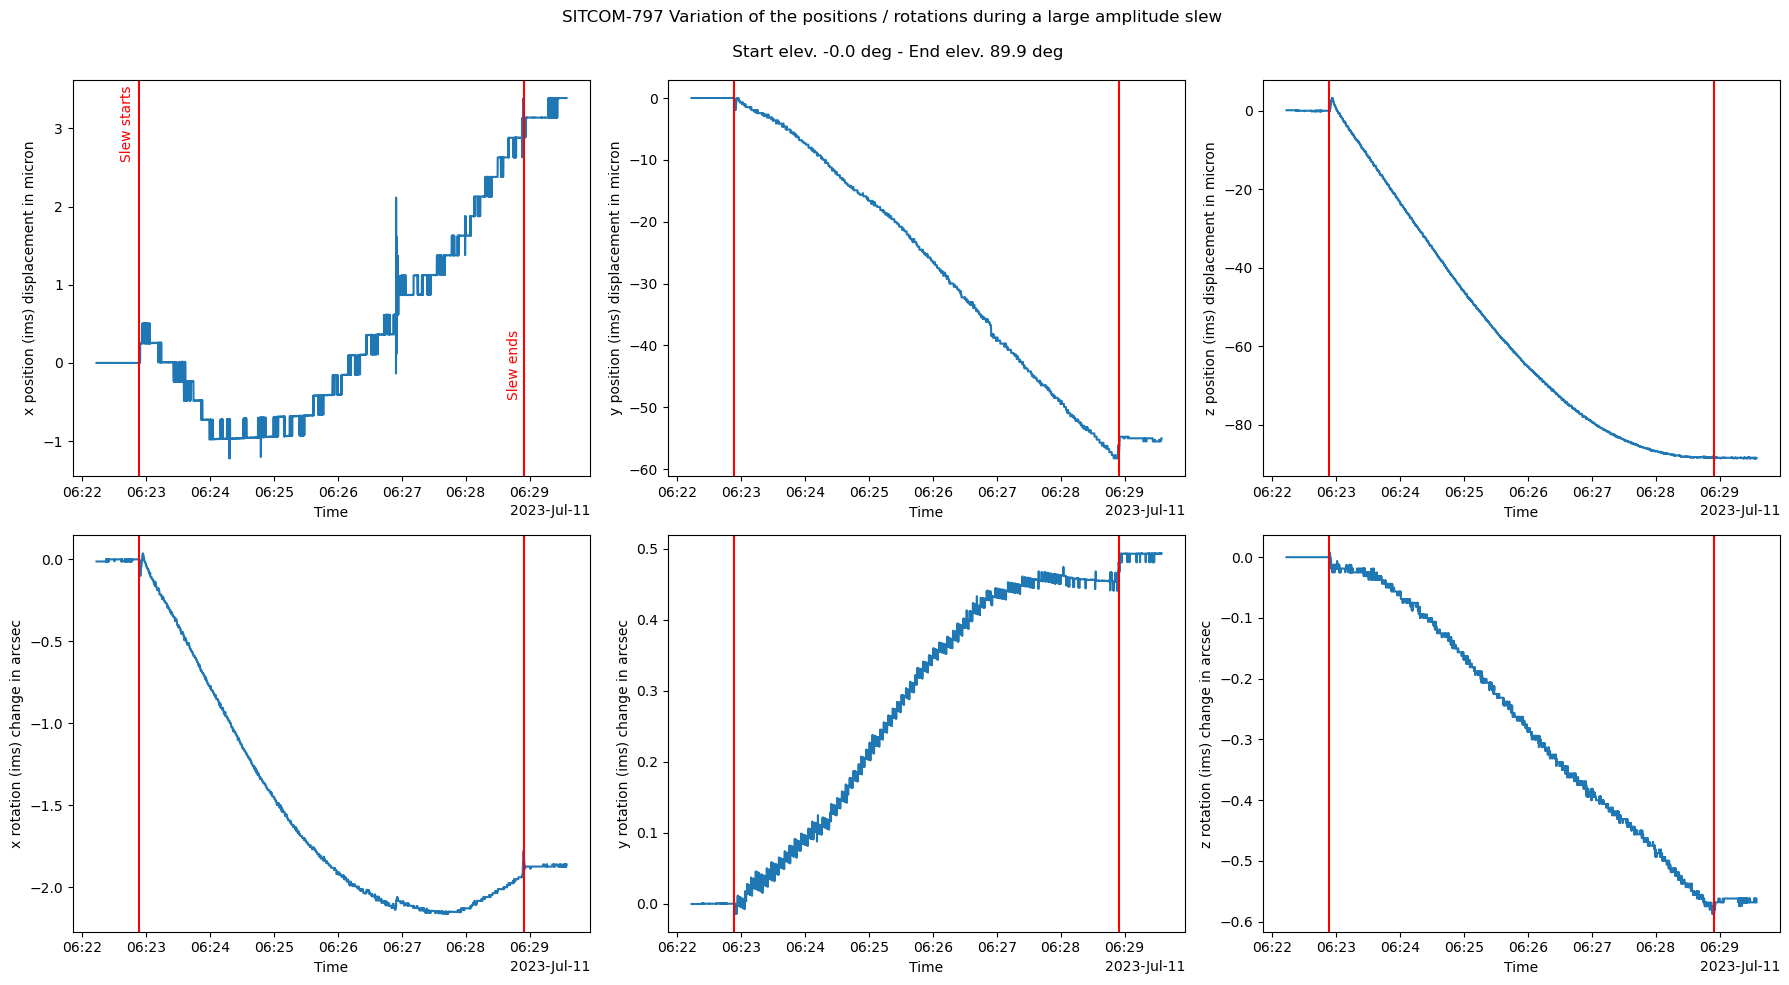

In [14]:
# Plot positions and rotation versus time

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = (
    "SITCOM-797 Variation of the positions / rotations during a large amplitude slew \n\n Start elev. %.1f deg - End elev. %.1f deg"
    % (
        results["start_ele"][ele_index],
        results["end_ele"][ele_index],
    )
)
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

axes = "xyz"
for i in range(3):
    axis = axes[i]

    # Positions
    _ = axs[0][i].plot(
        df_ims.index,
        (
            results[f"{axis}_before"][ele_index]
            - df_ims[f"{axis}Position"] * u.m.to(u.mm)
        )
        * u.mm.to(u.micron),
    )
    axs[0][i].axvline(df_ims_slew.index[0], c="r")
    axs[0][i].axvline(df_ims_slew.index[-1], c="r")
    axs[0][i].set_xlabel("Time")
    axs[0][i].set_ylabel(f"{axis} position (ims) displacement in micron")
    axs[0][i].xaxis.set_major_formatter(formatter)

    # Rotations
    _ = axs[1][i].plot(
        df_ims.index,
        (results[f"R_{axis}_before"][ele_index] - df_ims[f"{axis}Rotation"])
        * u.degree.to(u.arcsec),
    )
    axs[1][i].axvline(df_ims_slew.index[0], c="r")
    axs[1][i].axvline(df_ims_slew.index[-1], c="r")
    axs[1][i].set_xlabel("Time")
    axs[1][i].set_ylabel(f"{axis} rotation (ims) change in arcsec")
    axs[1][i].xaxis.set_major_formatter(formatter)

axs[0][0].text(
    0.09,
    0.8,
    "Slew starts",
    rotation=90,
    transform=axs[0][0].transAxes,
    color="r",
)

axs[0][0].text(
    0.84,
    0.2,
    "Slew ends",
    rotation=90,
    transform=axs[0][0].transAxes,
    color="r",
)

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Conclusion

From the previous plots we see that apart from a few glitches at the beginning and the end of the slews, M1M3 is moving smoothly during the slew.

## Preliminary conclusions

From the previous study we conclude that the specifications are not met, especially for the piston >70 microns instead of 1 micron.
After discussion with Douglas Neill, it was realized that the M1M3 displacement during slews is in fact normal and will be automatically compensated by M2 
and camera position adjustements

It seems more sensible to check the M1M3 displacement after a slew for a given value of the elevation. The idea is that if we move the TMA away and bring it back to the
original elevation, then M1M3 should also be back to the original position. 

This is the purpose of the analysis in the following cells. 

# Study mirror displacement for a given value of the elevation

In [15]:
def select_good(results):
    # Create a mask to flag obvious outliers - To do so we just compare each before slew and after slew positions / rotations to the
    # median positions / rotations computed over all the slews. We flag any entry that deviates significantly from the median.
    good = np.array(len(results))
    good.fill(True)
    axes = "xyz"
    for i in axes:
        for j in ["_before", "_after"]:
            m_pos = abs(results[f"{i}{j}"] - np.median(results[f"{i}{j}"])) < 0.1
            m_rot = abs(results[f"R_{i}{j}"] - np.median(results[f"R_{i}{j}"])) < 0.01
            good = good & m_pos & m_rot
    print(
        f"{len(results)-np.sum(good)} entries over {len(results)} flagged as outliers"
    )
    return good

21 entries over 123 flagged as outliers


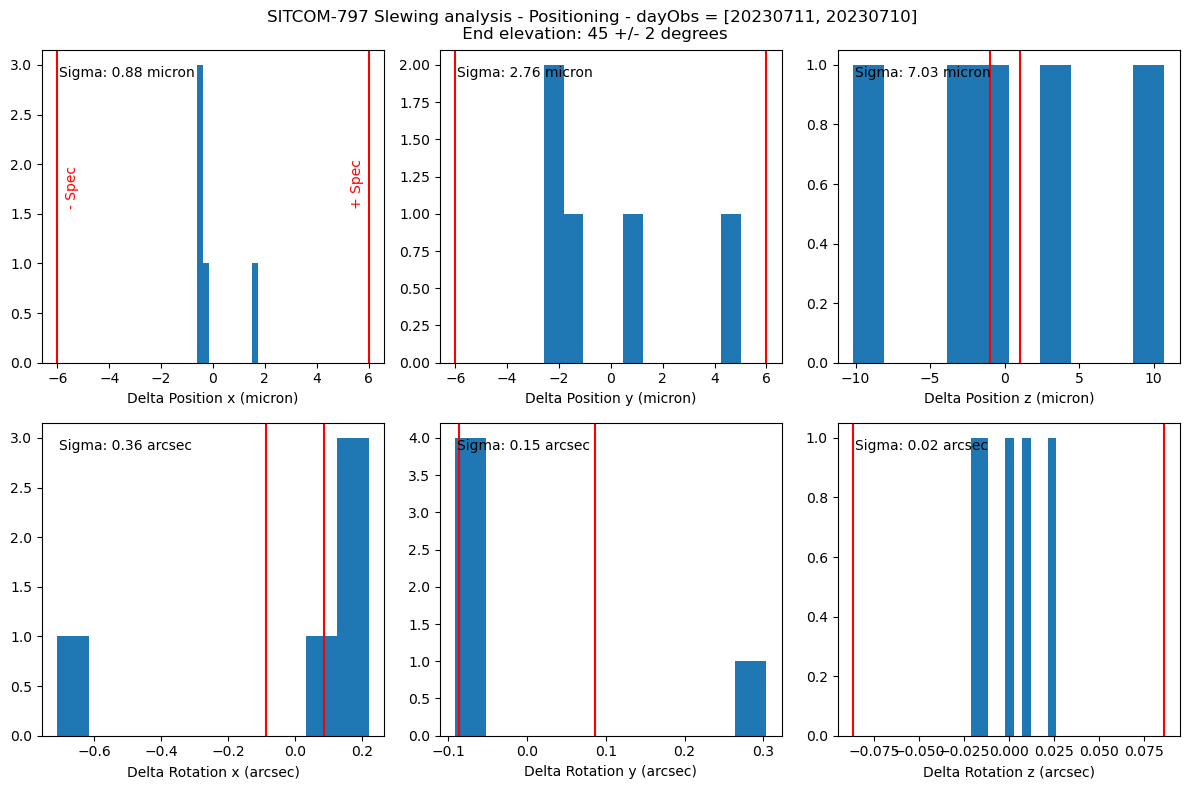

In [16]:
elev_target = 45  # The analysis is performed for a given elevation
elev_tol = 2  # Tolerance on the elevation value (we will keep any elevation that is within +/- elev_tol degrees of the target)

axes = "xyz"

# Flag outliers
good = select_good(results)

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs} \n End elevation: {elev_target} +/- {elev_tol} degrees "
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

# Check whether the TMA actually move significantly in elevation
diff_ele = abs(results.start_ele - results.end_ele)
mask_move = (diff_ele > 20) & good

# Accept a small variation around the selected elevation
mask_stop = abs(results.end_ele - elev_target) < elev_tol

for i in range(3):
    pos = results[f"{axes[i]}_after"][mask_move & mask_stop]
    avg = np.mean(pos)
    std = np.std(avg - pos) * u.mm.to(u.micron)
    axs[0][i].hist((avg - pos) * u.mm.to(u.micron))
    axs[0][i].set_xlabel(f"Delta Position {axes[i]} (micron)")
    axs[0][i].text(
        0.05,
        0.95,
        "Sigma: %.2f micron" % (std),
        transform=axs[0][i].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

    rot = results[f"R_{axes[i]}_after"][mask_move & mask_stop]
    avg = np.mean(rot)
    std = np.std(avg - rot) * u.degree.to(u.arcsec)
    axs[1][i].hist((avg - rot) * u.degree.to(u.arcsec))
    axs[1][i].set_xlabel(f"Delta Rotation {axes[i]} (arcsec)")
    axs[1][i].text(
        0.05,
        0.95,
        "Sigma: %.2f arcsec" % (std),
        transform=axs[1][i].transAxes,
        fontsize=10,
        verticalalignment="top",
    )

    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color="r")
        axs[0][i].axvline(-6, color="r")
        axs[1][i].axvline(0.0864, color="r")
        axs[1][i].axvline(-0.0864, color="r")
    else:
        axs[0][i].axvline(1, color="r")
        axs[0][i].axvline(-1, color="r")
        axs[1][i].axvline(0.0864, color="r")
        axs[1][i].axvline(-0.0864, color="r")

axs[0][0].text(
    -5.7,
    0.5,
    "- Spec",
    rotation=90,
    transform=axs[0][0].get_xaxis_transform(),
    color="r",
)

axs[0][0].text(
    5.3,
    0.5,
    "+ Spec",
    rotation=90,
    transform=axs[0][0].get_xaxis_transform(),
    color="r",
)

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

## Conclusions

Despite of the limited statistics we can see that the M1M3 displacement is still out of specs but the deviation is smaller

More data would be useful to draw definitive conclusions